In [11]:
import csv
import datetime
import math
import matplotlib.pyplot as plt

from collections import defaultdict

KEY_COUNTRY = 1
KEY_DATES_START = 4

# Returns a proper `datetime` from `date_str` in a format like
# '1/22/20', which represents January 22nd, 2020.
def make_date(date_str):
    parts = date_str.split('/')
    assert(len(parts) == 3)
    return datetime.date(2000 + int(parts[2]), int(parts[0]), int(parts[1]))

class DayData(object):
    def __init__(self, confirmed, recovered, dead):
        self.confirmed = confirmed
        self.recovered = recovered
        self.dead = dead

    def __repr__(self):
        return 'c: {}, r: {}, d: {}'.format(self.confirmed, self.recovered, self.dead)

class Country(object):
    def __init__(self, name, population, kind_data):
        self.name = name
        self.population = population
        self.timeseries = [DayData(confirmed, recovered, dead)
            for confirmed, recovered, dead in
                zip(kind_data['confirmed'], kind_data['recovered'], kind_data['dead'])]

    def __repr__(self):
        return '{}: [{}]'.format(self.name, ', '.join(str(dd) for dd in self.timeseries))

    def _project(self, perm, dayfn):
        factor = 1000.0/self.population if perm else 1.0
        return [dayfn(day) * factor for day in self.timeseries]

    def confirmed(self, perm=False):
        return self._project(perm, lambda day: day.confirmed)

    def recovered(self, perm=False):
        return self._project(perm, lambda day: day.recovered)

    def dead(self, perm=False):
        return self._project(perm, lambda day: day.dead)

    def dispatch(self, series, perm=False):
        if series == 'confirmed':
            return self.confirmed(perm)
        elif series == 'recovered':
            return self.recovered(perm)
        elif series == 'dead':
            return self.dead(perm)
        else:
            raise Exception('unknown series in dispatch: ' + series)

def read_one_data_series(series):
    country_data = dict()
    with open('data/{}.csv'.format(series)) as fin:
        reader = csv.reader(fin, delimiter=',', quotechar='"')
        header = next(reader)
        dates = [make_date(date_str) for date_str in header[KEY_DATES_START:]]
        for line in reader:
            name = line[KEY_COUNTRY]
            vals = [int(v) for v in line[KEY_DATES_START:]]
            assert(len(vals) == len(dates))
            if name not in country_data:
                country_data[name] = vals
            else:
                # Another province/state for the same country.
                # We just sum this up.
                cur = country_data[name]
                assert(len(cur) == len(vals))
                for i in range(len(cur)):
                    cur[i] += vals[i]
    return dates, country_data

class DB(object):
    def __init__(self):
        self.dates = None
        # {country -> kind -> numbers}
        per_country = defaultdict(dict)
        for series in ['confirmed', 'recovered', 'dead']:
            dates, country_data = read_one_data_series(series)
            if self.dates is None:
                self.dates = dates
            else:
                # We're assuming all the dates are present in all the datasets.
                assert(self.dates == dates)
            if len(per_country) > 0:
                assert(set(per_country.keys()) == set(country_data.keys()))
            for country, vals in country_data.items():
                per_country[country][series] = vals

        # {country name -> population}
        populations = dict()
        with open('data/country_population.txt') as fin:
            for line in fin:
                parts = line.split(' ')
                populations[' '.join(parts[:-1])] = int(parts[-1])
        self.countries = dict()
        for name, kind_data in per_country.items():
            try:
                pop = populations[name]
            except:
                pop = 0
            self.countries[name] = Country(name, pop, kind_data)

    def country(self, country_name):
        return self.countries[country_name]

In [12]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

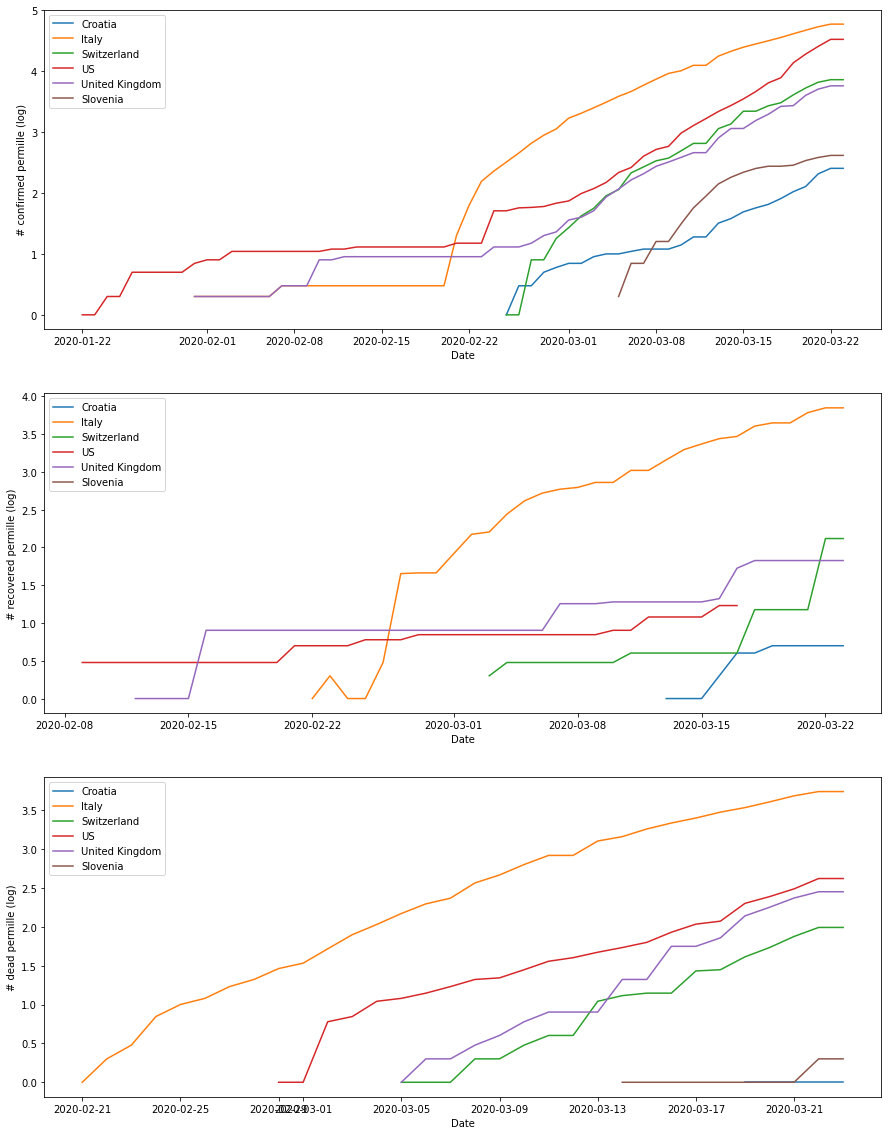

In [17]:
def log(lst):
    return [None if x == 0 else math.log10(x) for x in lst]

db = DB()

countries_to_plot = ['Croatia', 'Italy', 'Switzerland', 'US', 'United Kingdom', 'Slovenia']
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i, series in enumerate(['confirmed', 'recovered', 'dead']):
    ax = axes[i];
    for cname in countries_to_plot:
        ax.plot(db.dates, log(db.country(cname).dispatch(series)), label=cname)
    ax.set_ylabel('# {} permille (log)'.format(series))
    ax.set_xlabel('Date')
    ax.legend()

plt.show()

Croatia start date 2020-02-29
Best fit exponential: 1.3179439050359412 * exp10(0.09692207585559573 * t)
Best fit sigmoid: 964.7383840539576 / (1.0 + exp10(-0.11476424788253349 * (t - 27.493605530967)))


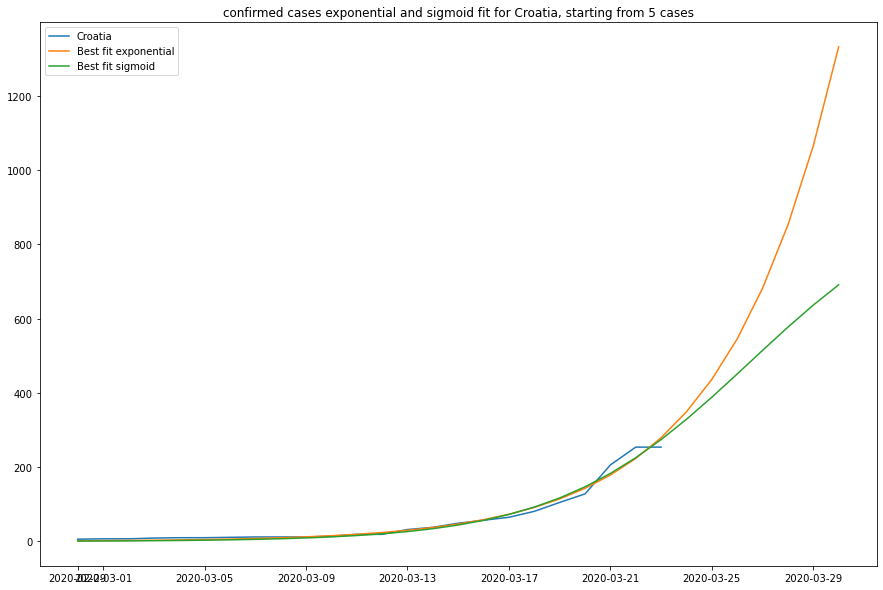

Italy start date 2020-02-21
Best fit exponential: 867.4732689134767 * exp10(0.05892022397937587 * t)
Best fit sigmoid: 95518.53846084236 / (1.0 + exp10(-0.09137507919297824 * (t - 29.18087388928112)))


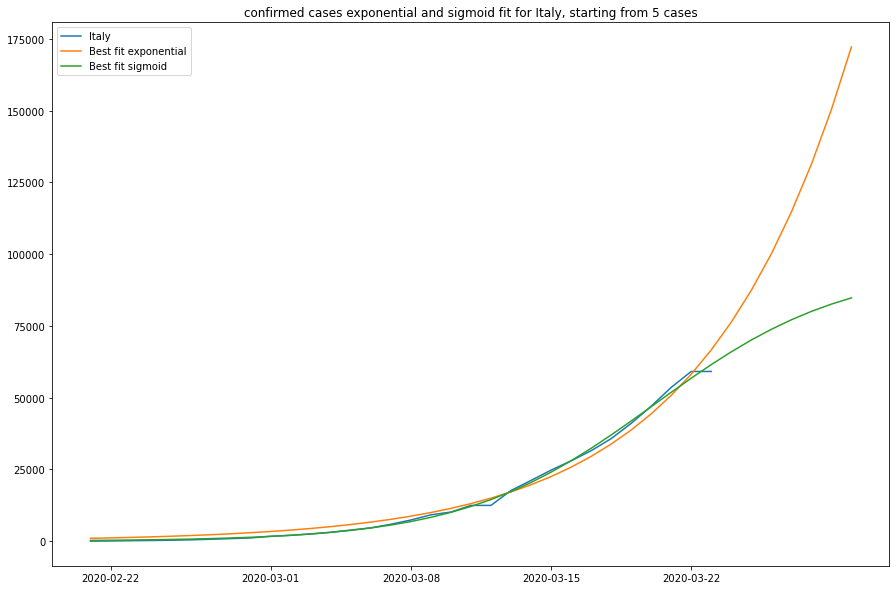

Switzerland start date 2020-02-27
Best fit exponential: 65.2507757310147 * exp10(0.08090780332146515 * t)
Best fit sigmoid: 11521.260136253683 / (1.0 + exp10(-0.1312114460181036 * (t - 23.673535843378033)))


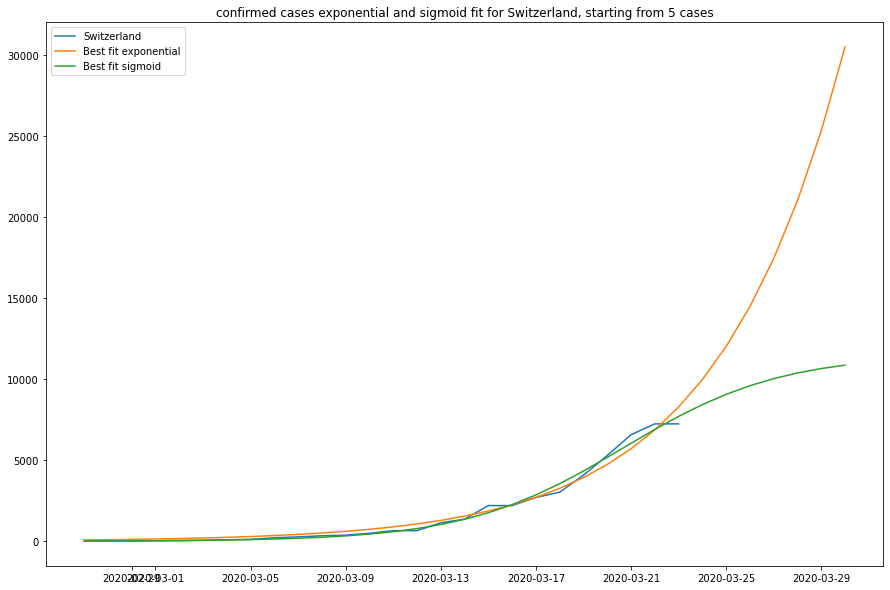

US start date 2020-01-31
Best fit exponential: 0.03626969587980688 * exp10(0.11354217926046695 * t)
Best fit sigmoid: 45683.0825098685 / (1.0 + exp10(-0.21797111367098046 * (t - 50.595515895484205)))


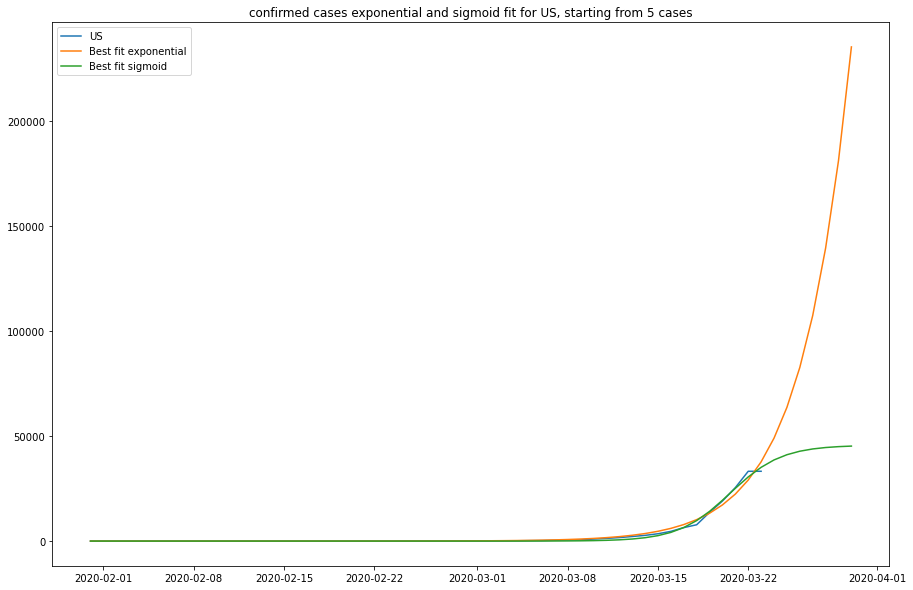

United Kingdom start date 2020-02-10
Best fit exponential: 1.4022789363781158 * exp10(0.08528195536605893 * t)
Best fit sigmoid: 9622.38423755257 / (1.0 + exp10(-0.1340242562149279 * (t - 41.197316239540505)))


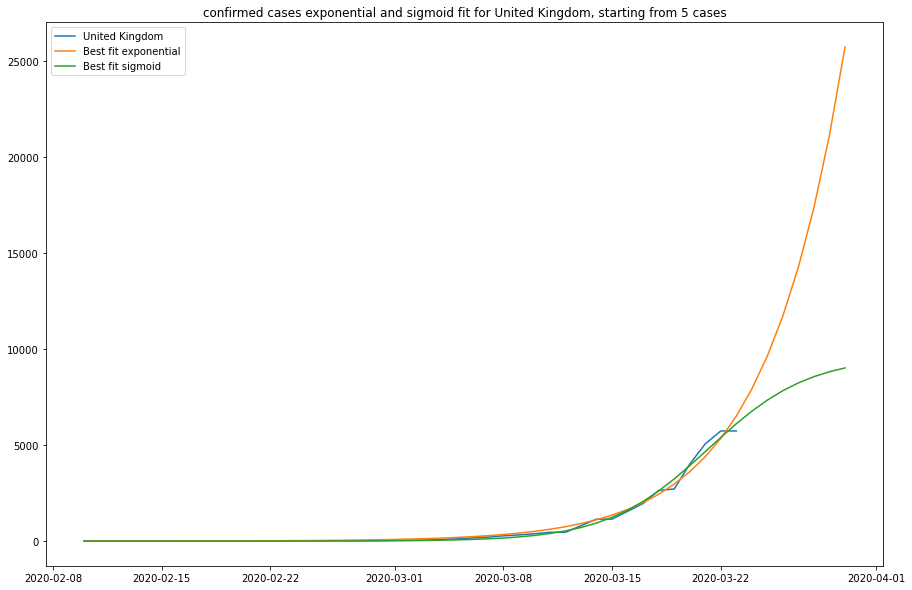

Slovenia start date 2020-03-06
Best fit exponential: 45.313515872339615 * exp10(0.056846847532042014 * t)
Best fit sigmoid: 425.796645587536 / (1.0 + exp10(-0.15737188739428432 * (t - 10.462394582658106)))


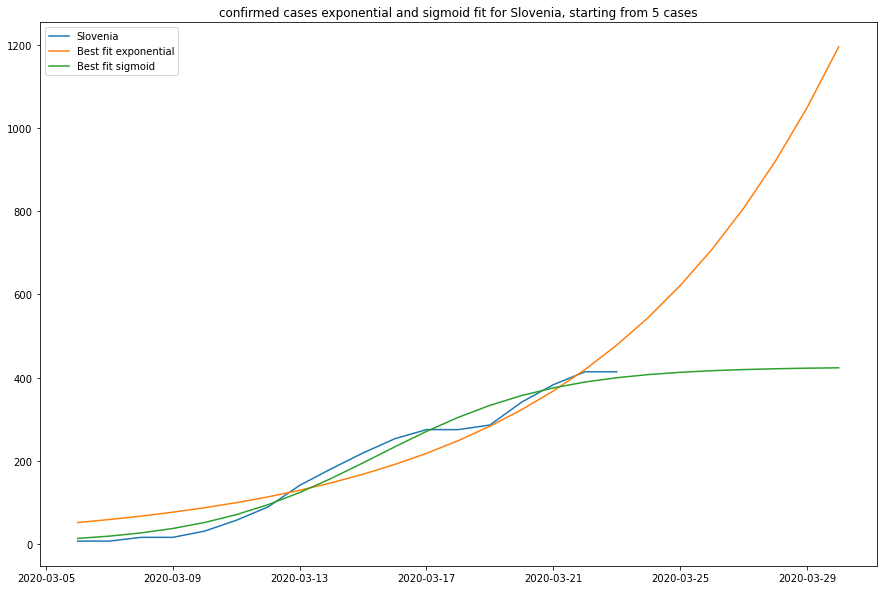

In [50]:
import numpy as np

from scipy.optimize import curve_fit
from scipy.special import exp10

def get_start_and_align(country_name, series, start_val, perm):
    data = db.country(country_name).dispatch(series, perm=perm)
    for i, (t, val) in enumerate(zip(db.dates, data)):
        if val > start_val:
            return db.dates[i:], data[i:]

def exponential(t, a, b):
    return a * exp10(b * t)

def sigmoid(t, a, b, c):
    return a / (1.0 + exp10(-b * (t - c)))

DAYS_EXTEND = 7

def country_exp_vs_sigmoid(country, series):
    dates, data = get_start_and_align(country, series, 5, perm=False)
    print('{} start date {}'.format(country, dates[0]))
    (aexp, bexp), _ = curve_fit(exponential, np.arange(1, len(data) + 1), data, p0=(1, 0.3))
    print('Best fit exponential: {} * exp10({} * t)'.format(aexp, bexp))
    (asig, bsig, csig), _ = curve_fit(sigmoid, np.arange(1, len(data) + 1), data, p0=(data[-1], 0.2, 21))
    print('Best fit sigmoid: {} / (1.0 + exp10(-{} * (t - {})))'.format(asig, bsig, csig))

    ts_extended = np.arange(1, len(data) + 1 + DAYS_EXTEND)
    dates_extended = dates[::] + [dates[-1] + datetime.timedelta(days=d) for d in range(1, DAYS_EXTEND + 1)]
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(dates, data, label=country)
    ax.plot(dates_extended, exponential(ts_extended, aexp, bexp), label='Best fit exponential')
    ax.plot(dates_extended, sigmoid(ts_extended, asig, bsig, csig), label='Best fit sigmoid')
    ax.set_title('{} cases exponential and sigmoid fit for {}, starting from 5 cases'.format(series, country))
    ax.legend()
    plt.show()

for country in countries_to_plot:
    country_exp_vs_sigmoid(country, 'confirmed')

Korea, South start date 2020-01-31
Best fit exponential: 550.8892516670517 * exp10(0.02488128891568772 * t)
Best fit sigmoid: 8482.438087268069 / (1.0 + exp10(-0.1355373179432379 * (t - 31.988816788143865)))


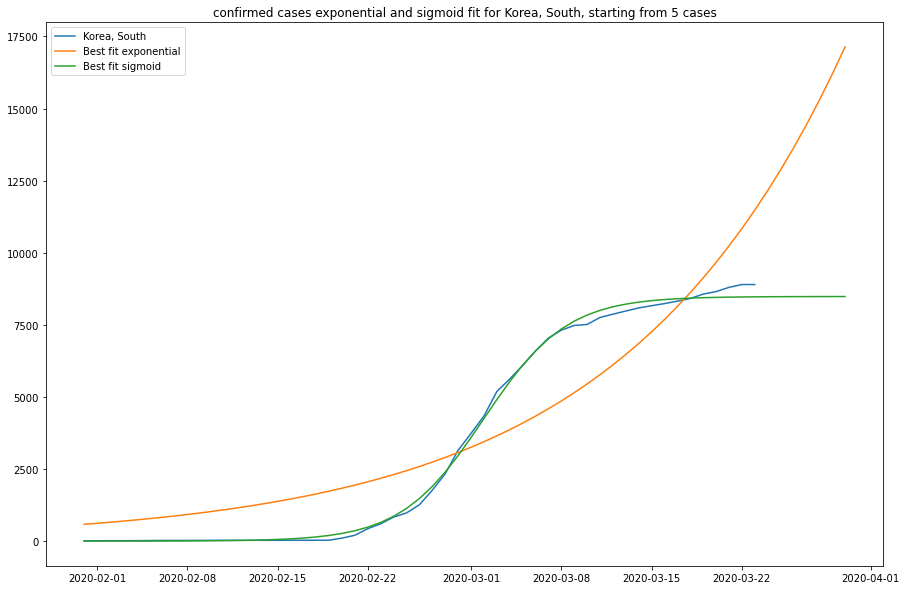

Japan start date 2020-01-28
Best fit exponential: 27.97797560066934 * exp10(0.02931821209938441 * t)
Best fit sigmoid: 1427.0410749877503 / (1.0 + exp10(-0.05208082647197907 * (t - 46.29779222734583)))


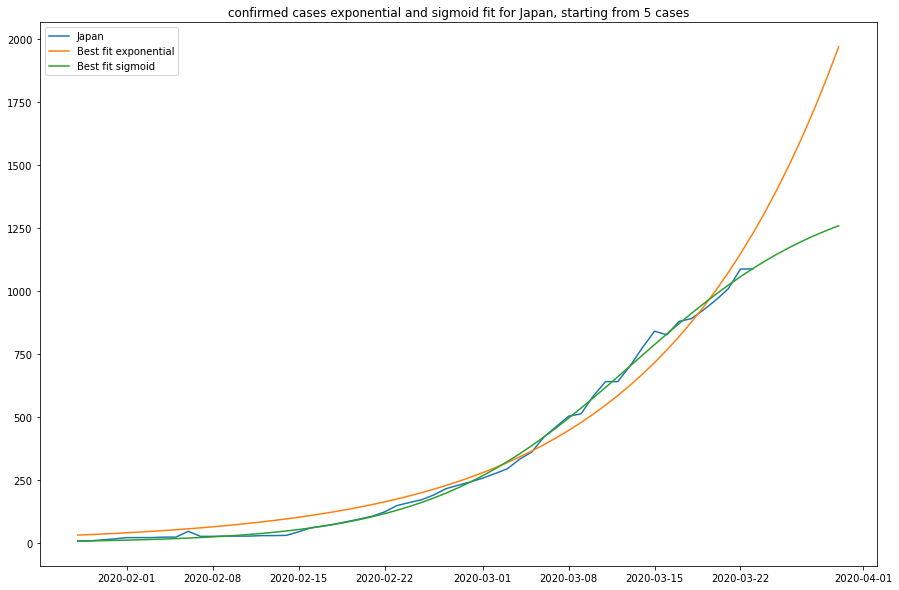

China start date 2020-01-22
Best fit exponential: 27480.346416114284 * exp10(0.009299107645810335 * t)
Best fit sigmoid: 80997.1698603251 / (1.0 + exp10(-0.09626951377389024 * (t - 18.76894718072673)))


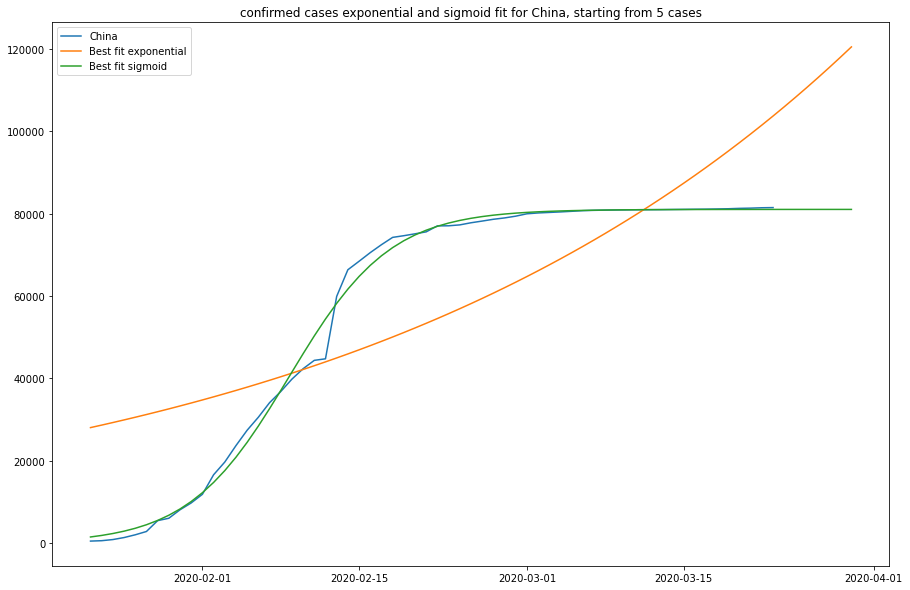

In [54]:
recovering_countries = ['Korea, South', 'Japan', 'China']
for country in recovering_countries:
    country_exp_vs_sigmoid(country, 'confirmed')

Best fit exponential Croatia: 0.00013214953837466776 * exp10(0.09683892059674924 * t)
Best fit exponential Italy: 0.014347454954918284 * exp10(0.05892022300614674 * t)
Best fit exponential Switzerland: 0.005181504608006332 * exp10(0.08094860618909817 * t)
Best fit exponential US: 5.8172507853989295e-05 * exp10(0.11354243069885658 * t)
Best fit exponential United Kingdom: 2.0656408705718e-05 * exp10(0.0852819383135035 * t)
Best fit exponential Slovenia: 0.018489414875120805 * exp10(0.05771712917412516 * t)


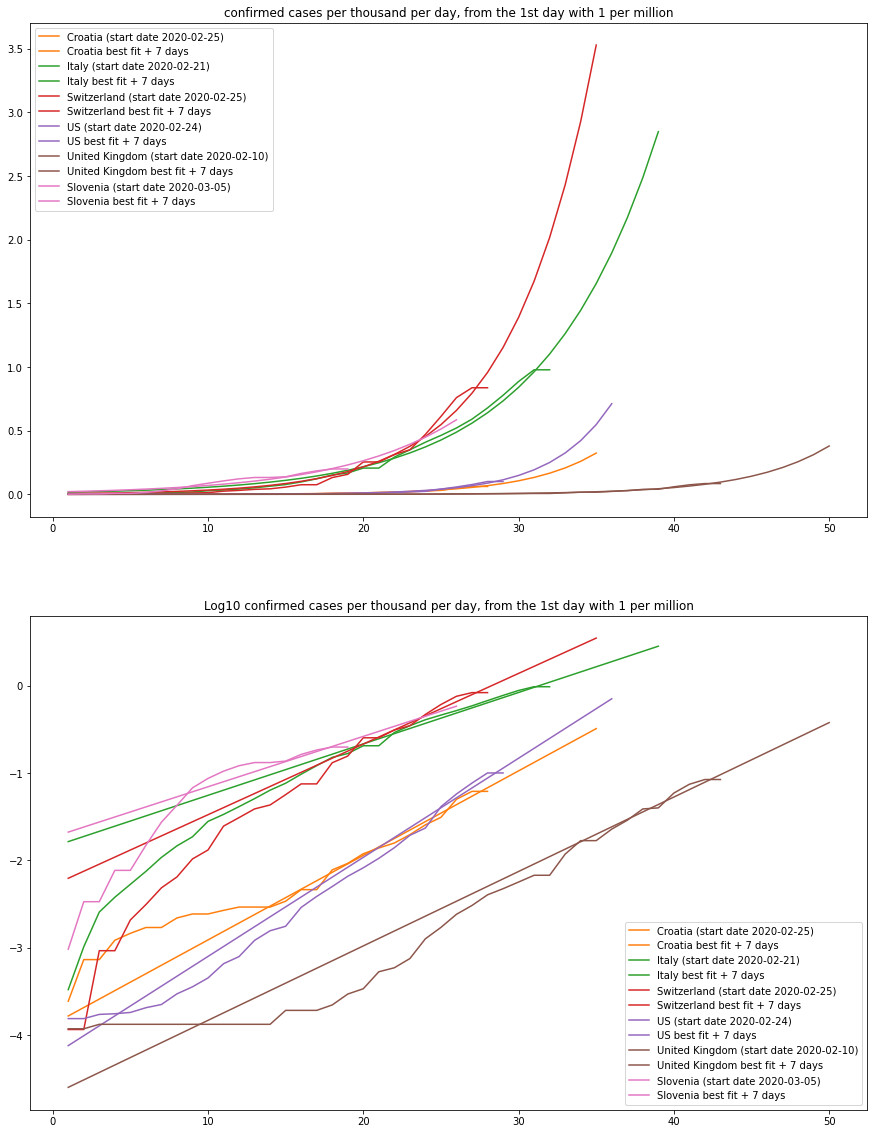

In [36]:
def identity(lst):
    return lst

def compare_countries(series, countries, start_value=(0.0001, '1 per million')):
    fig, axes = plt.subplots(2, 1, figsize=(15, 20))

    for cidx, country in enumerate(countries):
        # Start each country when they had 1 case per million.
        dates, data = get_start_and_align(country, series, start_value[0], perm=True)
        data_label = '{} (start date {})'.format(country, dates[0])
        fit_label = '{} best fit + {} days'.format(country, DAYS_EXTEND)
        xs = np.arange(1, len(data) + 1)
        (aexp, bexp), _ = curve_fit(exponential, xs, data, p0=(1, 0.3))
        print('Best fit exponential {}: {} * exp10({} * t)'.format(country, aexp, bexp))
    
        xs_extended = np.arange(1, len(xs) + 1 + DAYS_EXTEND)
        color = 'C{}'.format(cidx + 1)
    
        for fnidx, fn in enumerate([identity, log]):
            ax = axes[fnidx]
            ax.plot(xs, fn(data), color, label=data_label)
            ax.plot(xs_extended, fn(exponential(xs_extended, aexp, bexp)), color, label=fit_label)

    axes[0].legend()
    axes[0].set_title('{} cases per thousand per day, from the 1st day with {}'.format(series, start_value[1]))
    axes[1].legend()
    axes[1].set_title('Log10 {} cases per thousand per day, from the 1st day with {}'.format(series, start_value[1]))
    plt.show()
    
compare_countries('confirmed', countries_to_plot)

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Best fit exponential Croatia: 0.0002435895160240918 * exp10(-2.431579219355201e-10 * t)
Best fit exponential Italy: 0.0005987933784026415 * exp10(0.06974741377090529 * t)
Best fit exponential Switzerland: 0.00012585638486687305 * exp10(0.1054109585981218 * t)
Best fit exponential US: 6.3482923207053954e-06 * exp10(0.09747215894711449 * t)
Best fit exponential United Kingdom: 4.079903648561467e-05 * exp10(0.10902270839073387 * t)
Best fit exponential Slovenia: 0.0003253120917125435 * exp10(0.04184753273614757 * t)


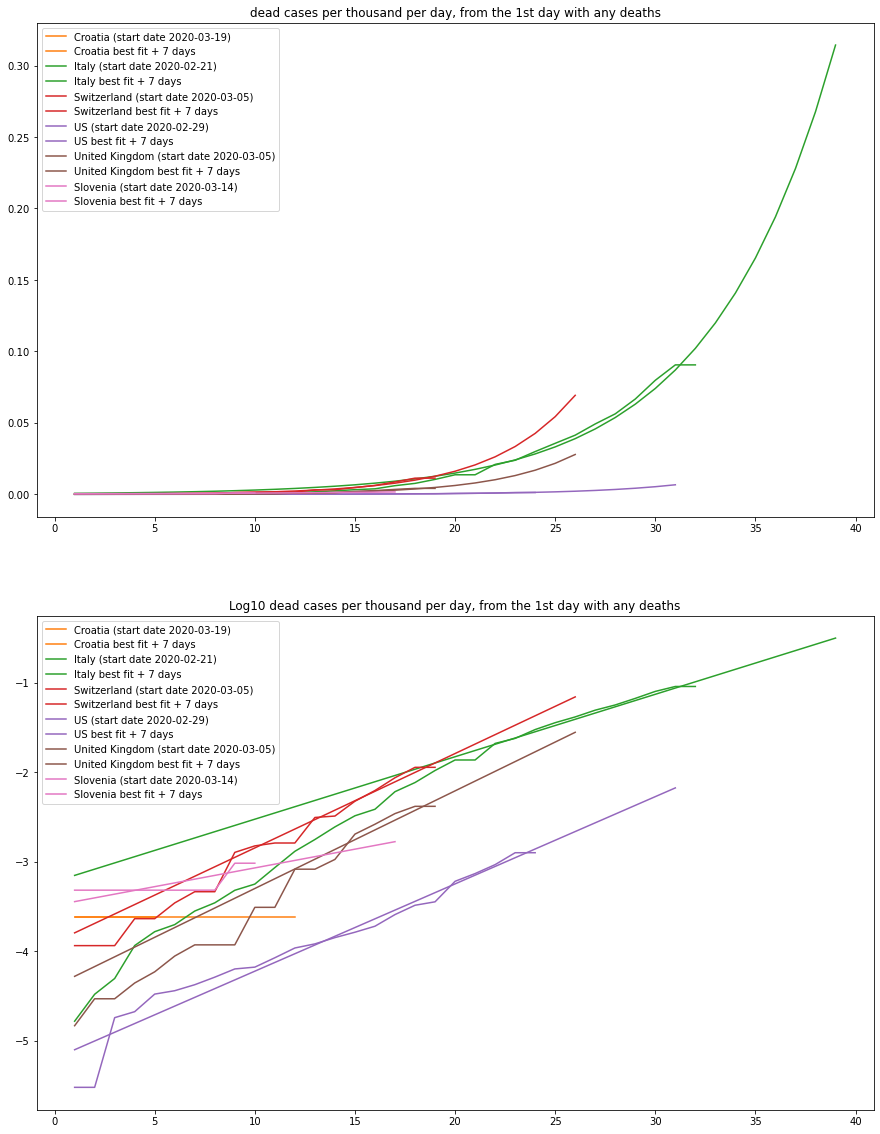

In [35]:
# Not reliable for many of these countries as they are still in early stages!
compare_countries('dead', countries_to_plot, start_value=(0, 'any deaths'))